In [10]:
import pandas as pd
import numpy as np
from pydantic import BaseModel, Field, ValidationError, validator
import matplotlib.pyplot as plt
from typing import List, Tuple
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')

In [128]:
class ProfitLossSimulation(BaseModel):

    S0: float = Field(..., gt=0, description="Initial stock price")
    E: float = Field(..., gt=0, alias="strike", description="Strike price")
    mu: float = Field(..., ge=0, le=1, alias="rate", description="rate")
    sigma_actual: float = Field(..., gt=0, le=1, description="actual Volatility")
    sigma_imp: float = Field(..., gt=0, le=1, description="implied Volatility")
    T: int = Field(..., gt=0, le=3650, alias="dates", description="Days to expiration")
    N_paths: int = Field(..., gt=0, alias="npaths", description="Number of simulations")
    n_steps: int = Field(252, gt=0, alias="timesteps", description="Number of timesteps")
   

    class Config:
        allow_population_by_field_name = True

     
        
    @property
    def pseudorandomnumber(self) -> np.ndarray:
        
        np.random.seed(2025)
        w = np.random.standard_normal((self.n_steps, self.N_paths))
        
        return w

    @property
    def pathsimulation(self) -> np.ndarray:
        
        dt = self.T / self.n_steps

        S = np.zeros((self.n_steps, self.N_paths))
        S[0] = self.S0
        w = self.pseudorandomnumber

        for i in range(0, self.n_steps-1):
           
            S[i+1,:] = S[i,:] * (1 + self.mu*dt + self.sigma_actual*np.sqrt(dt)*w[i,:])
           
        return S

    
    def d_one(self, sigma: float) -> np.ndarray:
         
        S = self.pathsimulation
        dt = self.T / self.n_steps
        

        
        d1 = np.zeros((self.n_steps, self.N_paths))

        for i in range(0, self.n_steps-1):
            
            t = dt * i
            tau = self.T - t
            d1[i,:]= (np.log(S[i,:]/self.E) + (self.mu + 0.5*sigma**2)*tau) / (sigma*np.sqrt(tau))

           

        return d1

    
    @property
    def deltacalculation(self):


        delta_imp = np.zeros((self.n_steps, self.N_paths))
        delta_actual = np.zeros((self.n_steps, self.N_paths))
        
        d1_imp = self.d_one(self.sigma_imp)
        d1_actual = self.d_one(self.sigma_actual)
     
        delta_imp = norm.cdf(d1_imp)
        delta_actual = norm.cdf(d1_actual)
            

        return delta_imp, delta_actual


    @property
    def gammacalculation(self) -> np.ndarray:
        
        S = self.pathsimulation
        dt = self.T / self.n_steps

        gamma_imp = np.zeros((self.n_steps, self.N_paths))
        d1_imp = self.d_one(self.sigma_imp)

        for i in range(0, self.n_steps-1):
            
            t = dt * i
            tau = self.T - t

            gamma_imp[i,:] = norm.pdf(d1_imp[i,:]) / (self.sigma_imp * S[i,:] * np.sqrt(tau))


        return gamma_imp

    @property
    def profit_loss(self) -> np.ndarray:
        
        dt = self.T / self.n_steps
        
        P_L = np.zeros((self.n_steps, self.N_paths))

        PL_dt = np.zeros((self.n_steps, self.N_paths))
        
        S = self.pathsimulation
            

        delta_imp, delta_actual = self.deltacalculation
      
        gamma_imp = self.gammacalculation
        
        w = self.pseudorandomnumber
        
        for i in range(0, self.n_steps-1):
            
            BM = np.sqrt(dt)* w[i,:]
            
            drift_term = 0.5*(self.sigma_actual**2 - self.sigma_imp**2)*(S[i,:]**2)*gamma_imp[i,:]*dt
            
            diffusion_term = +(delta_imp[i,:]-delta_actual[i,:])*self.sigma_actual*S[i,:]*BM
            

            P_L[i+1,:] = P_L[i,:]+ drift_term + diffusion_term

            PL_dt[i,:] = drift_term + diffusion_term

        return P_L, PL_dt


In [130]:
simulation01 = ProfitLossSimulation(
                            S0=100, 
                            strike=100, 
                            rate=0.05, 
                            sigma_actual=0.3,
                            sigma_imp=0.2, 
                            dates=1, 
                            npaths=100000, 
                            n_steps=252
                )

In [168]:

gamma_matrix = simulation01.gammacalculation
expected_gamma = np.mean(gamma_matrix, axis = 1)

In [169]:
expected_gamma.shape

(252,)

In [172]:
expected_gamma = expected_gamma.reshape(-1,1)

In [174]:
expected_gamma.shape

(252, 1)

In [140]:
gamma_matrix.shape

(252, 100000)

Text(0.5, 1.0, 'Time-dependent Gamma')

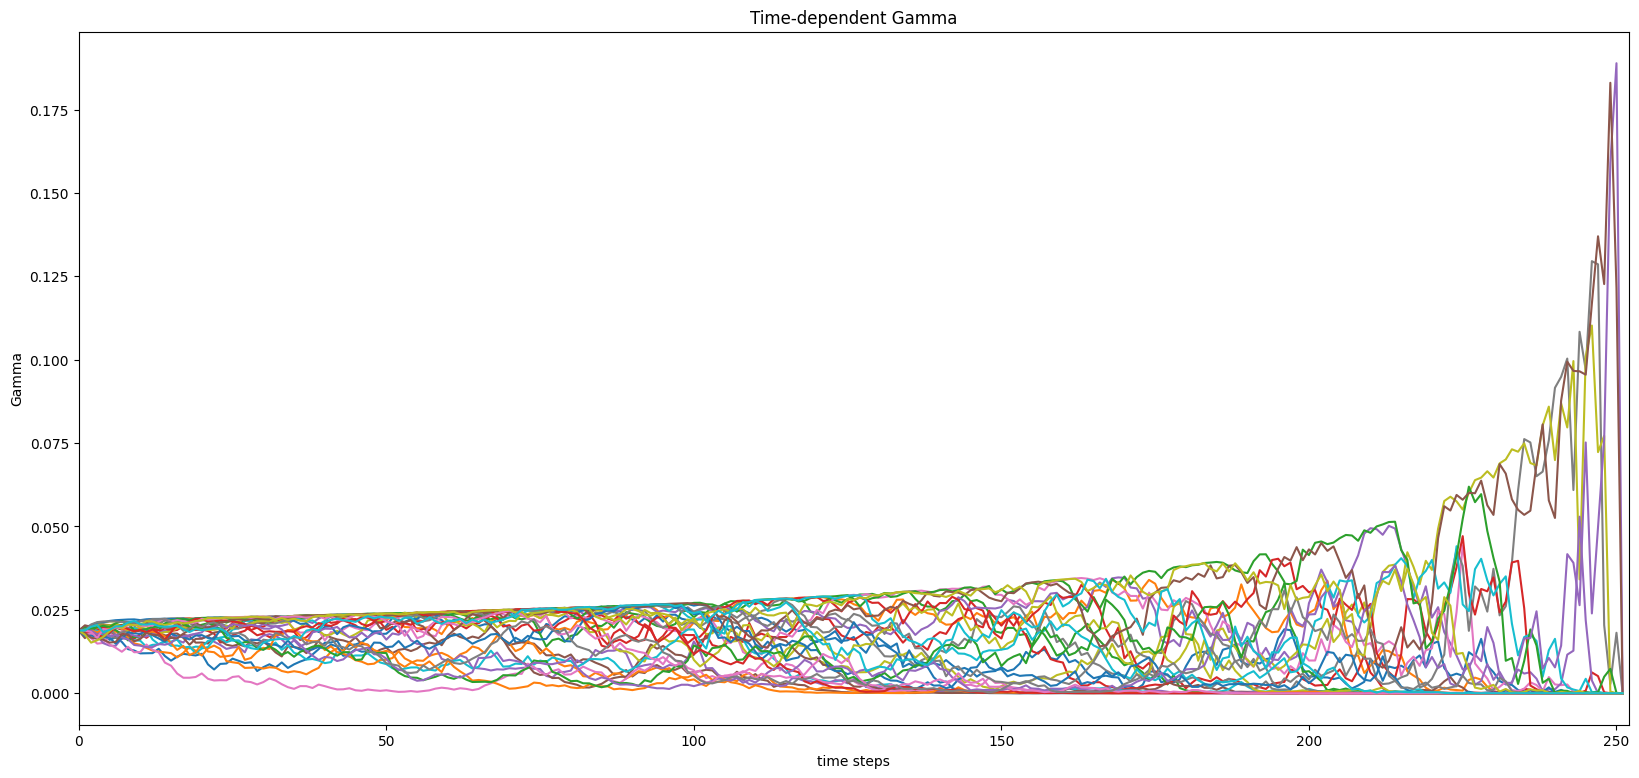

In [142]:
plt.figure(figsize=(20,9))
plt.plot(gamma_matrix[:,:30] )
plt.xlabel('time steps')
plt.xlim(0,252)
plt.ylabel('Gamma')
plt.title('Time-dependent Gamma')

Text(0.5, 1.0, 'Time-dependent Gamma')

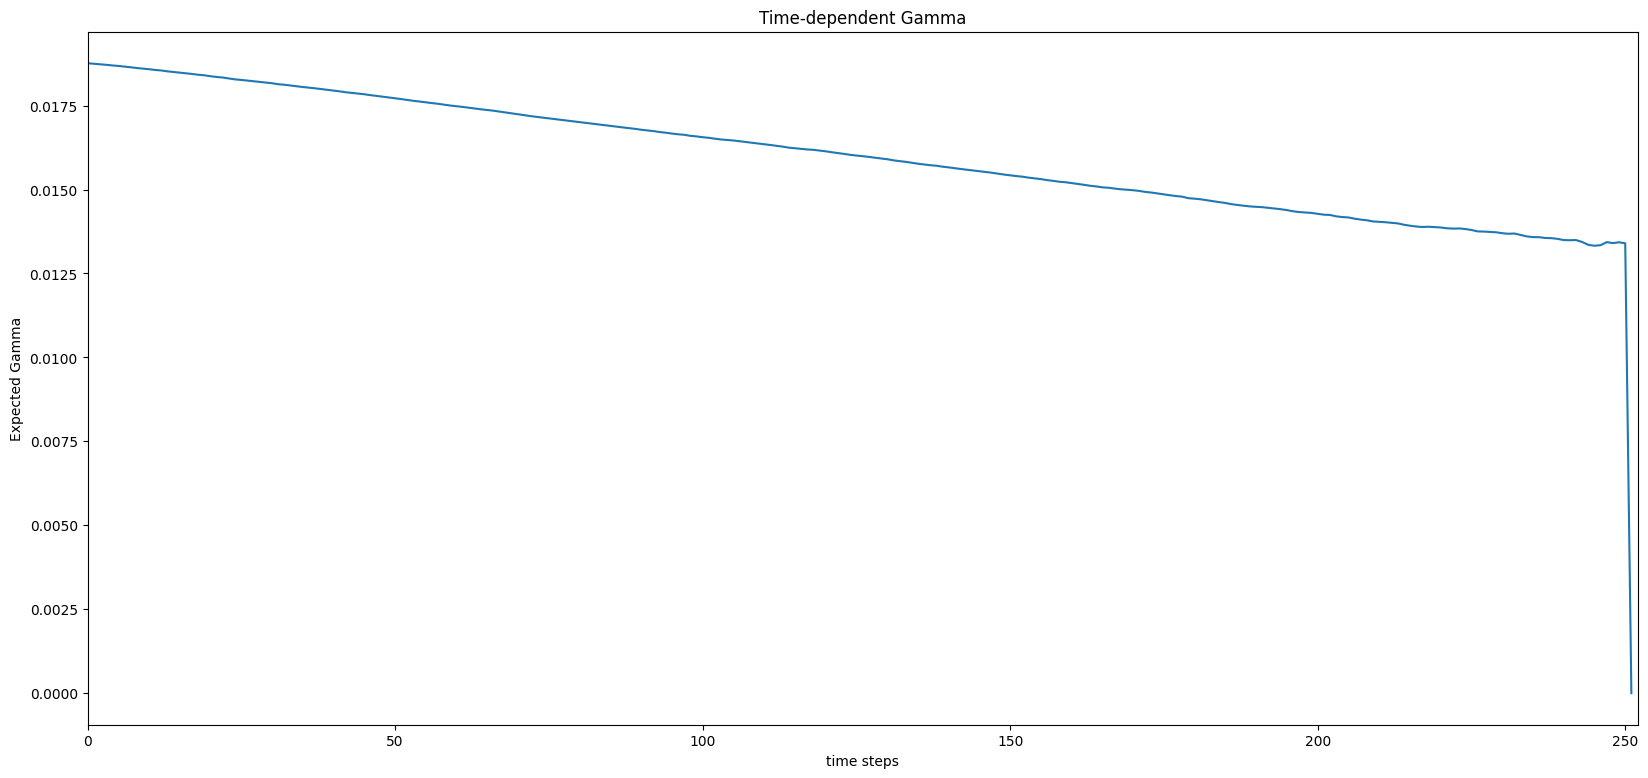

In [150]:
plt.figure(figsize=(20,9))
plt.plot(expected_gamma)
plt.xlabel('time steps')
plt.xlim(0,252)
plt.ylabel('Expected Gamma')
plt.title('Time-dependent Gamma')

Text(0.5, 1.0, 'P&L for every time step')

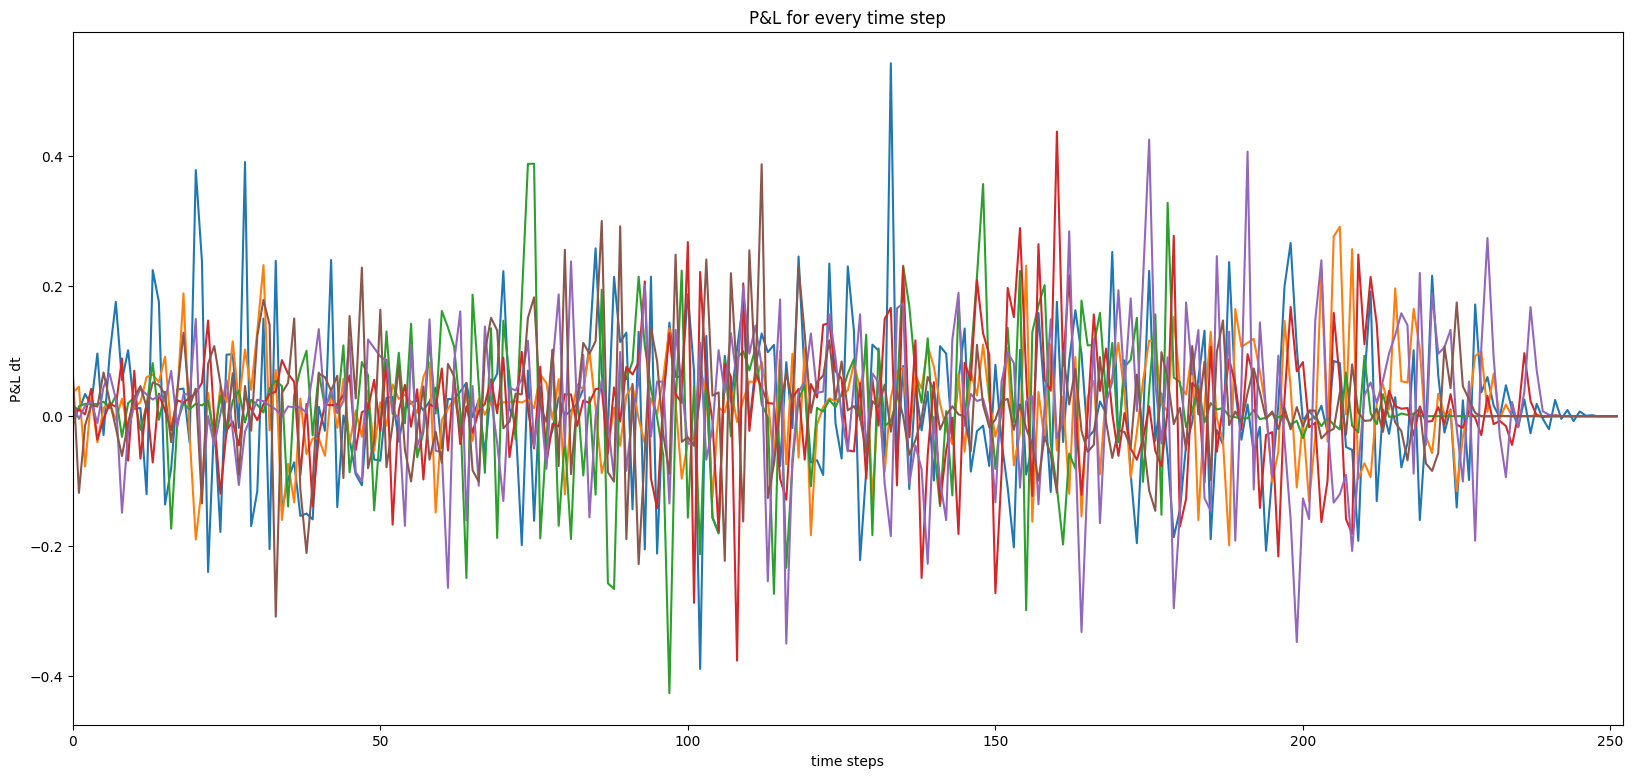

In [152]:
plt.figure(figsize=(20,9))
plt.plot(PL_dt[:,:6])
plt.xlabel('time steps')
plt.xlim(0,252)
plt.ylabel('P&L dt')
plt.title('P&L for every time step')

Text(0.5, 1.0, 'Simulation of Accumulated P&L - Actual Volatility')

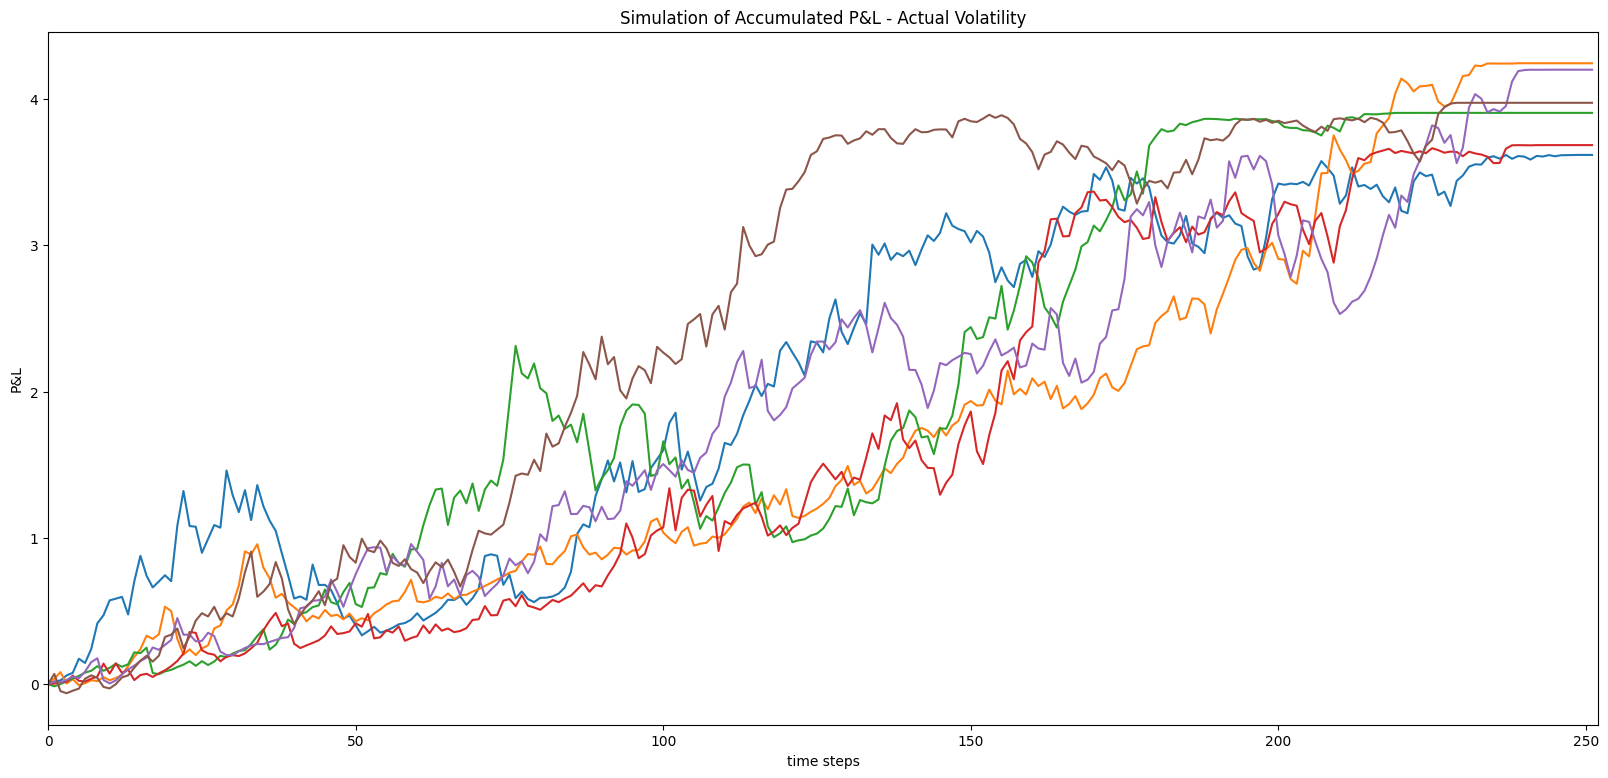

In [154]:
plt.figure(figsize=(20,9))
plt.plot(PandL[:,:6])
plt.xlabel('time steps')
plt.xlim(0,252)
plt.ylabel('P&L')
plt.title('Simulation of Accumulated P&L - Actual Volatility')

In [156]:
PandL, PL_dt = simulation01.profit_loss

Text(0.5, 1.0, 'Expection of Accumulated P&L - Actual Volatility')

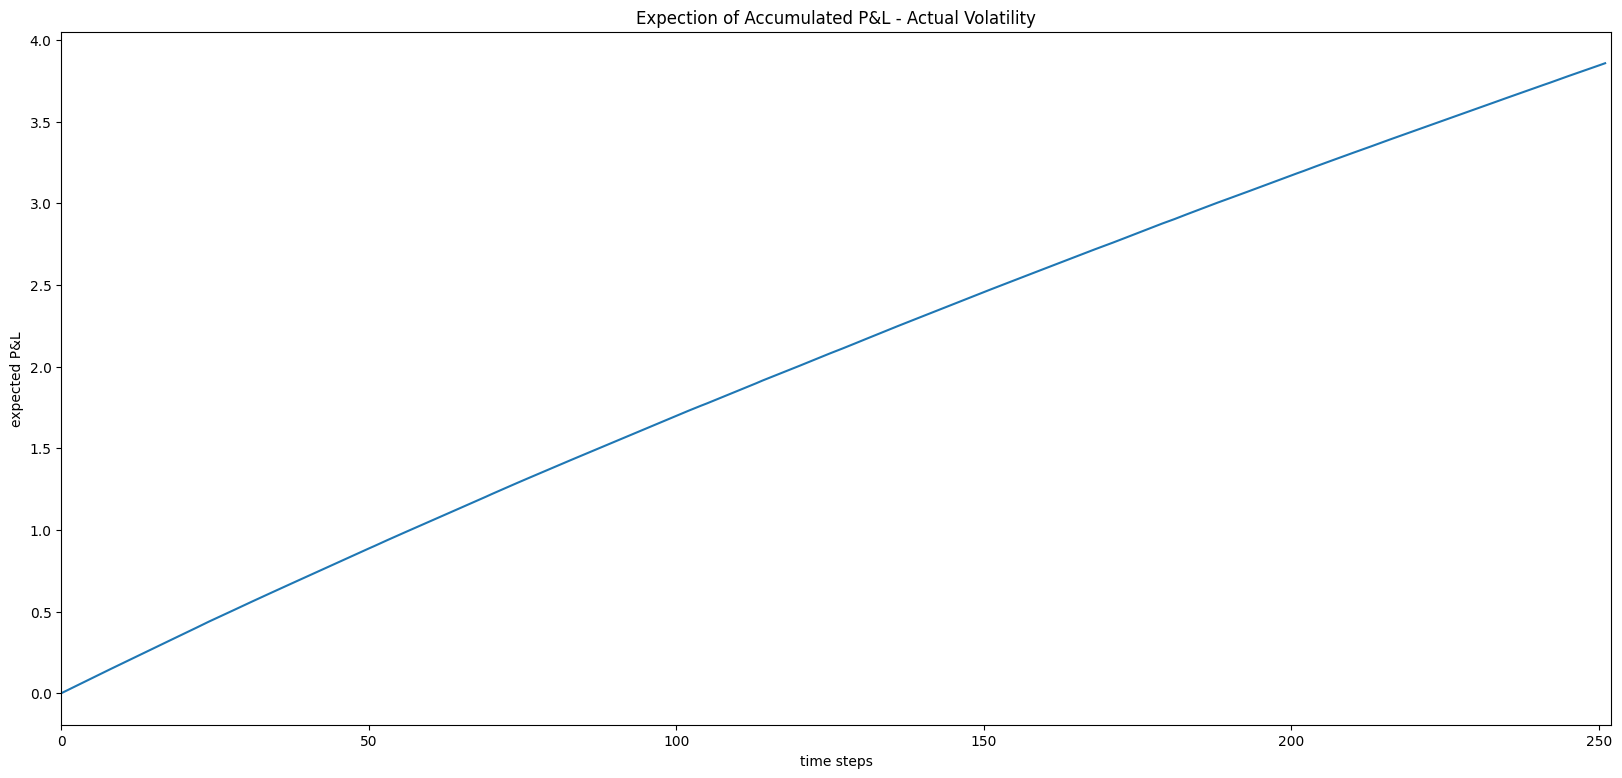

In [201]:
plt.figure(figsize=(20,9))
plt.plot(expected_PandL)
plt.xlabel('time steps')
plt.xlim(0,252)
plt.ylabel('expected P&L')
plt.title('Expection of Accumulated P&L - Actual Volatility')

In [176]:
expected_PLdt = np.mean(PL_dt, axis = 1).reshape(-1,1)

In [178]:
expected_PLdt.shape

(252, 1)

Text(0.5, 1.0, 'Expected P&L for every time step')

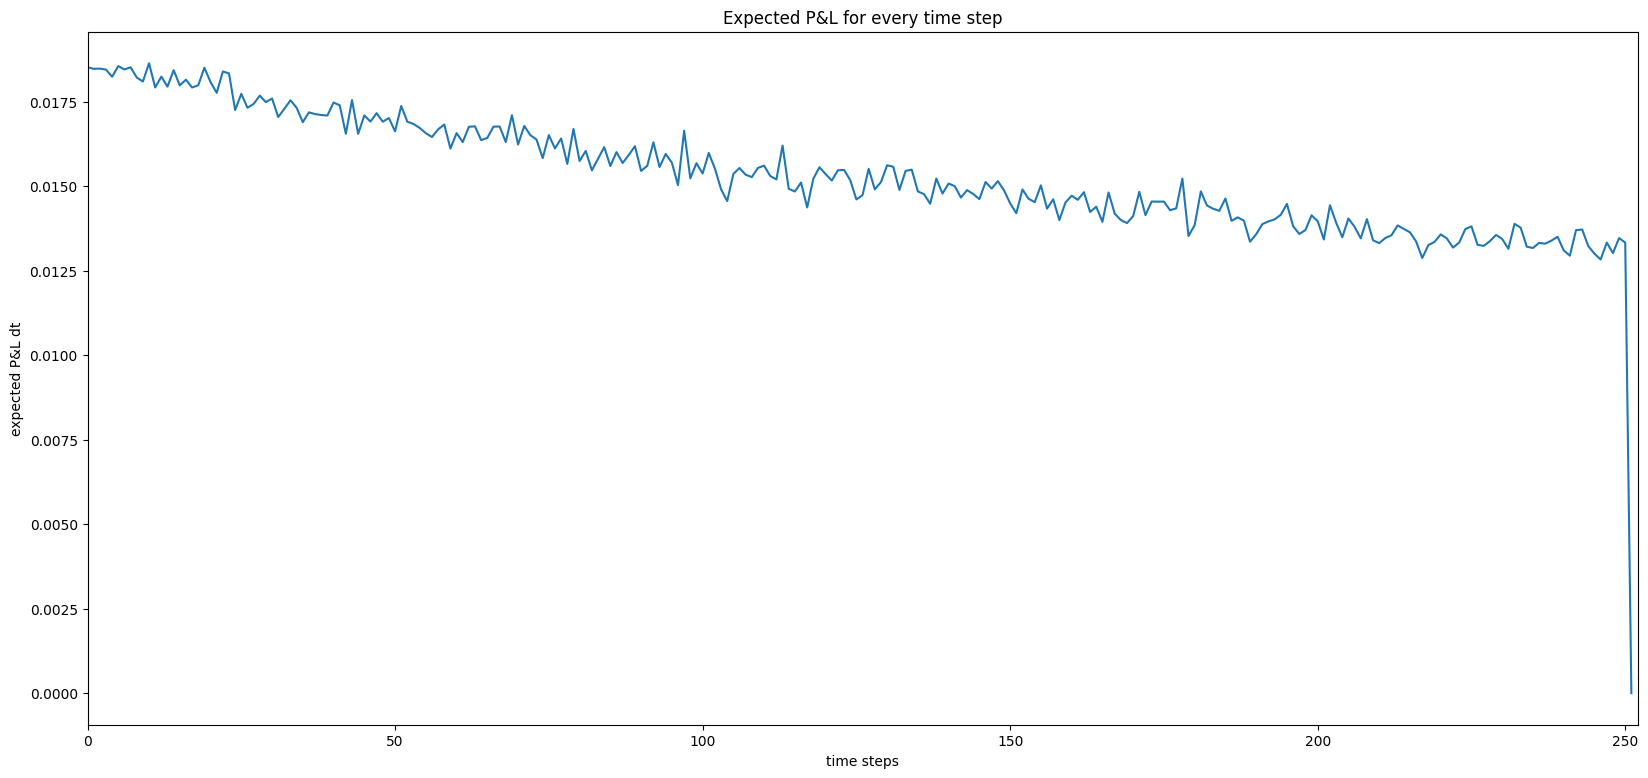

In [159]:
plt.figure(figsize=(20,9))
plt.plot(expected_PLdt)
plt.xlabel('time steps')
plt.xlim(0,252)
plt.ylabel('expected P&L dt')
plt.title('Expected P&L for every time step')

In [184]:
corr = np.corrcoef(expected_gamma.flatten(), expected_PLdt.flatten())[0,1]

In [186]:
print(corr)

0.9769331290652004


In [191]:
expected_PandL = np.mean(PandL, axis = 1).reshape(-1,1)

In [193]:
expected_PandL.shape

(252, 1)

In [197]:
corr02 = np.corrcoef(expected_gamma.flatten(), expected_PandL.flatten())[0,1]

In [199]:
print(corr02)

-0.8992009279705362


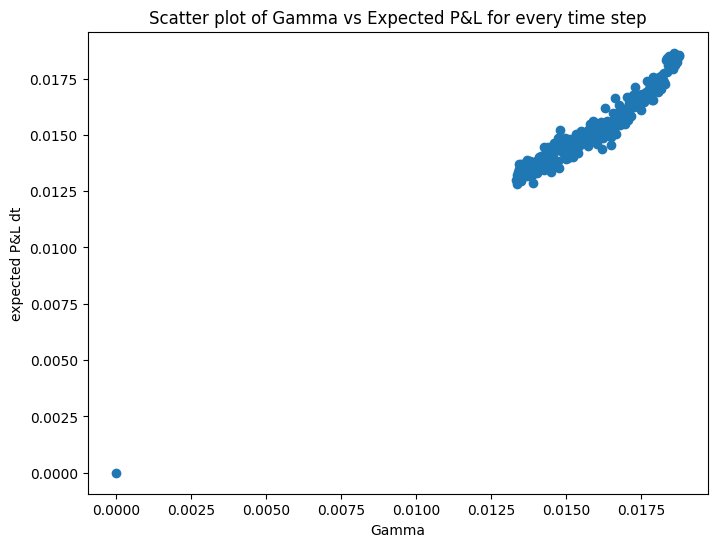

In [205]:
plt.figure(figsize=(8,6))
plt.scatter(expected_gamma, expected_PLdt)
plt.xlabel('Gamma')
plt.ylabel('expected P&L dt')
plt.title('Scatter plot of Gamma vs Expected P&L for every time step')
plt.show()

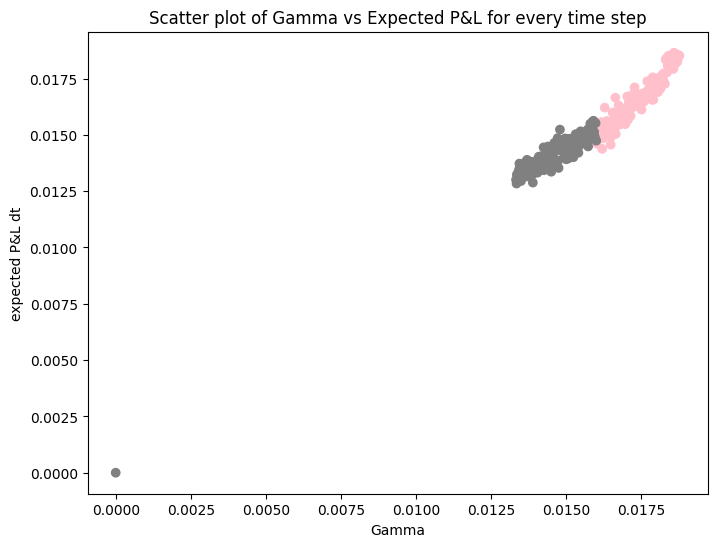

In [215]:
plt.figure(figsize=(8,6))
n = len(expected_gamma)
colors = ['pink' if i < n//2 else 'grey' for i in range(n)]
plt.scatter(expected_gamma, expected_PLdt, c=colors)
plt.xlabel('Gamma')
plt.ylabel('expected P&L dt')
plt.title('Scatter plot of Gamma vs Expected P&L for every time step')
plt.show()

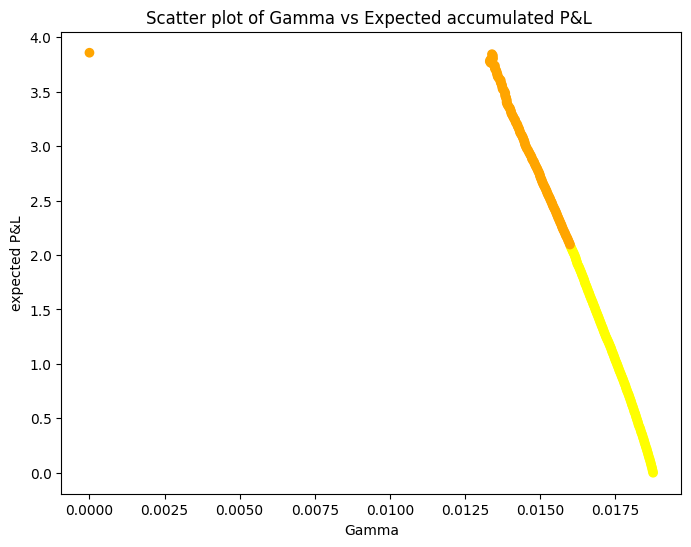

In [225]:
plt.figure(figsize=(8,6))
n = len(expected_gamma)
colors = ['yellow' if i < n//2 else 'orange' for i in range(n)]
plt.scatter(expected_gamma, expected_PandL, c=colors)
plt.xlabel('Gamma')
plt.ylabel('expected P&L')
plt.title('Scatter plot of Gamma vs Expected accumulated P&L ')
plt.show()

In [227]:
import statsmodels.api as sm

In [231]:
y = expected_PLdt.flatten()

In [233]:
X = expected_gamma

In [235]:
X = sm.add_constant(X)

In [237]:
model = sm.OLS(y,X).fit()

In [239]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     5232.
Date:                Sat, 26 Apr 2025   Prob (F-statistic):          1.22e-169
Time:                        04:33:54   Log-Likelihood:                 1619.3
No. Observations:                 252   AIC:                            -3235.
Df Residuals:                     250   BIC:                            -3228.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      1.697      0.0

In [241]:
y = expected_PandL.flatten()
X = expected_gamma
X = sm.add_constant(X)
model = sm.OLS(y,X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     1056.
Date:                Sat, 26 Apr 2025   Prob (F-statistic):           1.00e-91
Time:                        04:38:10   Log-Likelihood:                -176.00
No. Observations:                 252   AIC:                             356.0
Df Residuals:                     250   BIC:                             363.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.3805      0.259     40.145      0.0